In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from mpl_toolkits.mplot3d import Axes3D

In [122]:
#Urtzi 
# @njit#(parallel=True)
# def Coulomb1(r): #Coulomb energy of a single particle
#     return np.sum(np.power(r,2))

@njit#(parallel=True)
def Coulomb2(r1,r2):    #Coulomb energy between two particles
    return 1/np.linalg.norm(r1-r2)

@njit#(parallel=True)
def Coulomb_3D_energy(N,r): #Coulomb energy of a system of N particles
    #E1 = 0
    E2 = 0
    for i in range(N):
        #E1 += Coulomb1(r[i])
        for j in range(i+1,N):
            E2 += Coulomb2(r[i],r[j])
    return E2#E1 + E2


@njit#(parallel=True)
def omega(r, r_trial, T, i):
    #E1 = -(Coulomb1(r_trial)-Coulomb1(r[i]))
    E2 = 0
    for index, vector in enumerate(r):
        if index != i:
            E2 += Coulomb2(r_trial,vector)-Coulomb2(r[i],vector)
    return (np.exp(-E2/T)), E2
#linalg and coulombenergy
@njit#(parallel=True)
def MonteCarlo_move(r,L,i,anplitud,T):
    r_trial = r[i] + (2*np.random.rand(3)-1)*anplitud
    r_trial[:] = r_trial[:] - np.floor(r_trial[:]/L)*L  
    w, Edif = omega(r,r_trial,T,i)
    if np.floor(w+np.random.rand()) > 0 or Edif < 0:
        r[i] = r_trial
        accept_ratio = 1
    else:
        accept_ratio = 0
        Edif = 0
    return r, Edif, accept_ratio

def main(rho,T):
    N = 200
    #rho = 0.5
    L = np.power(N/rho,1/3)
    #T = 1000
    it = 1000
    anplitud = 0.1
    #r = initialize_positions(N,L)
    r = random_positions(N,L)
    E = Coulomb_3D_energy(N,r)
    E_list = []
    acceptance = 0
    count = 0
    for j in range(it):
        for i in range(N):
            count += 1
            r, Edif, accept_ratio = MonteCarlo_move(r,L,i,anplitud,T)
            E += Edif
            acceptance += accept_ratio
            E_list.append(E)
        #T *= 0.999 #Annealing
    plot_positions(r,L)
    
    dr = L/100
    pair_distribution_function(r,L,N,T,dr)
    plt.show()
    print("Acceptance ratio: ", acceptance/count)
    print("Energy: ", E)

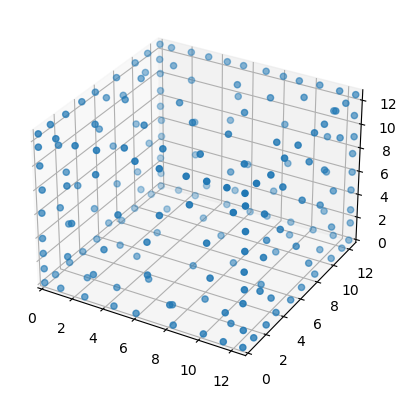

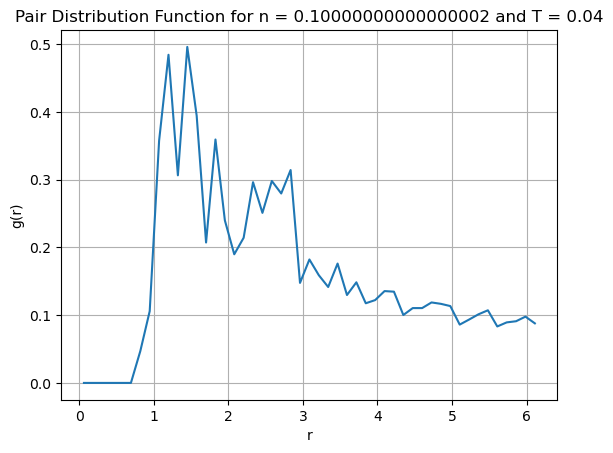

Acceptance ratio:  0.31325
Energy:  2184.7503912665734


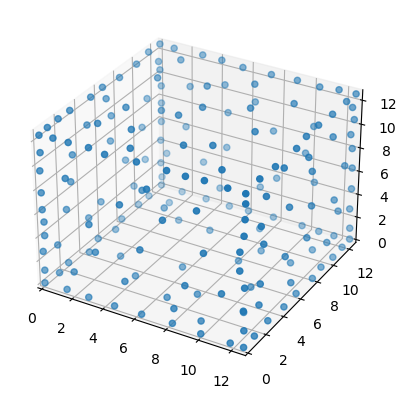

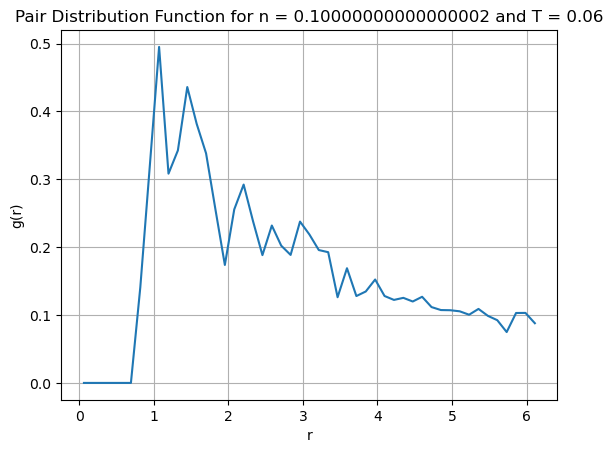

Acceptance ratio:  0.42142
Energy:  2194.7738294095293


In [137]:
vals_rho = [0.1] #list for different densities
vals_T = [0.04,0.06] #list for different temperatures
for rho in vals_rho:
    for T in vals_T:
        main(rho,T)

In [ ]:
vals_rho = [0.01,0.1,1,10,100,1000]
vals_T = [0.0001,0.001,0.01,0.1,1,10]
for rho in vals_rho:
    for T in vals_T:
        main(rho,T)

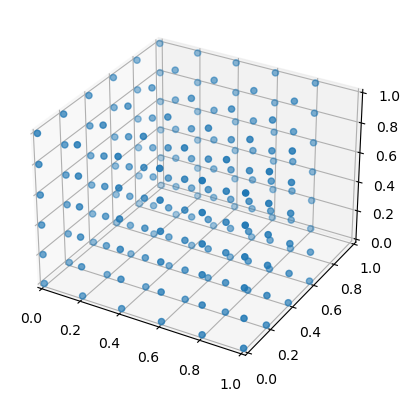

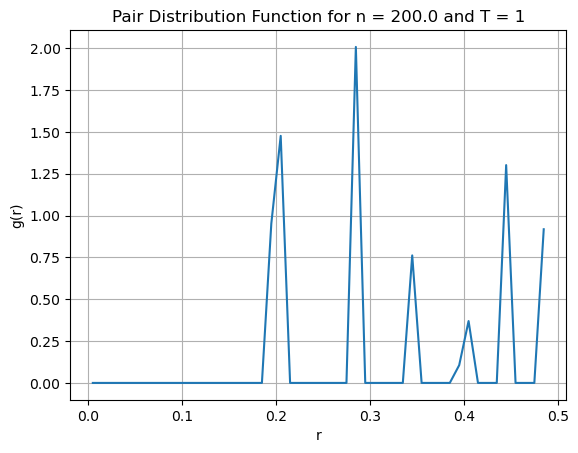

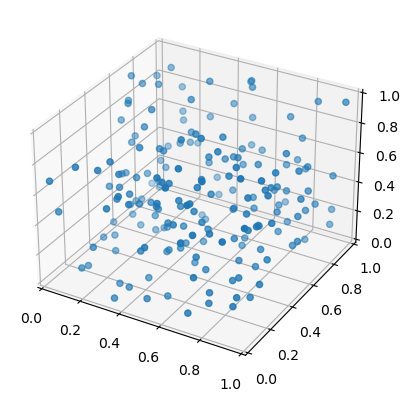

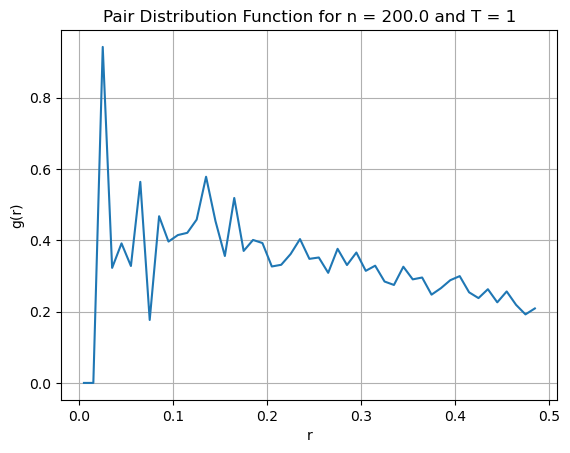

In [136]:
N = 200
L = 1
T = 1
dr = L/100
r = initialize_positions(N,L)
plot_positions(r,L)
pair_distribution_function(r, L, N, T, dr)
r = random_positions(N,L)
plot_positions(r,L)
pair_distribution_function(r, L, N, T, dr)

In [96]:
#cell for initializing positions
@njit
def initialize_positions(N, L): #Initialize positions in a cubic lattice
    n_side = int(np.ceil(N ** (1. / 3)))  # Number of particles along each side of the cube
    dx = L / (n_side - 1)  # Spacing between particles
    r = np.empty((N, 3))  # Array to hold positions
    n = 0  # Counter for number of positions filled
    for i in range(n_side):
        for j in range(n_side):
            for k in range(n_side):
                if n < N:  # Only fill N positions
                    r[n] = np.array([i*dx, j*dx, k*dx])
                    n += 1
    return r

@njit
def random_positions(N, L): #Initialize positions randomly
    r = np.random.rand(N,3)*L
    return r

In [101]:
def Boltzmann_distribution(N,L,T):
    r,E_list,_ = Wigner_crystal_Monte_Carlo(N,L,T)
    energy_levels, counts = np.unique(E_list, return_counts=True)
    boltzmann_distribution = counts / np.sum(counts)
    plt.plot(energy_levels, boltzmann_distribution)
    plt.xlabel('Energy')
    plt.ylabel('Probability')
    plt.show()
    return r,E_list

def plot_energy_distribution(N,L,T):
    r,E_list,_ = Wigner_crystal_Monte_Carlo(N,L,T)
    plt.hist(E_list,bins=100)
    plt.show()
    return r,E_list


#Cell for plotting

def plot_positions(r, L):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(r[:,0], r[:,1], r[:,2])
    ax.set_xlim([0, L])
    ax.set_ylim([0, L])
    ax.set_zlim([0, L])
    plt.show()

def pair_distribution_function(r, L, N, T, dr):
    # Calculate pairwise distances
    diff = r[:, np.newaxis, :] - r[np.newaxis, :, :]
    dist = np.sqrt(np.sum(diff**2, axis=-1))
    dist = dist[np.triu_indices(N, 1)]  # get upper triangular part

    # Create histogram
    bins = np.arange(0.0, L/2, dr) #or L/2
    hist, bin_edges = np.histogram(dist, bins=bins)

    # Normalize histogram
    rho = N / L**3  # number density
    shell_volume = 4/3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
    g = hist / (N * rho * shell_volume)
    bin_mids = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_mids, g)
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.title('Pair Distribution Function for n = '+str(N/L**3)+' and T = '+str(T))
    plt.grid(True)
    plt.show()

# def plot_g_r(r, L, dr, max_r):
#     g_r = pair_distribution_function(r, L, dr, max_r)
#     r_values = np.arange(0, max_r, dr)
#     plt.plot(r_values, g_r)
#     plt.xlabel('r')
#     plt.ylabel('g(r)')
#     plt.title('Pair Distribution Function')
#     plt.grid(True)
#     plt.show()






From the results obtained on these simulations:

vals_rho = [0.01,0.1,1,10,100,1000]\
vals_T = [0.0001,0.001,0.01,0.1,1,10]\
for rho in vals_rho:\
    for T in vals_T:\
        main(rho,T)

In total 36 MC runs for 6 different densities and Temperatures we obtained the following results for fixed densities:

### n=0.01
Phase transition occurs between 0.02 and 0.04
### n=0.1
Phase transition occurs between 0.04 and 0.07
### n=1
Phase transition occurs between 0.1 and 0.2
### n=10
Phase transition occurs between 0.3 and 0.4
### n=100
Phase transition occurs between 0.4 and 0.8
### n=1000
Phase transition occurs between 1 and 2

Thus, we clearly see that density affects as higher densities mantain a more ordered structure in high temperatures until they eventually become gaseous.

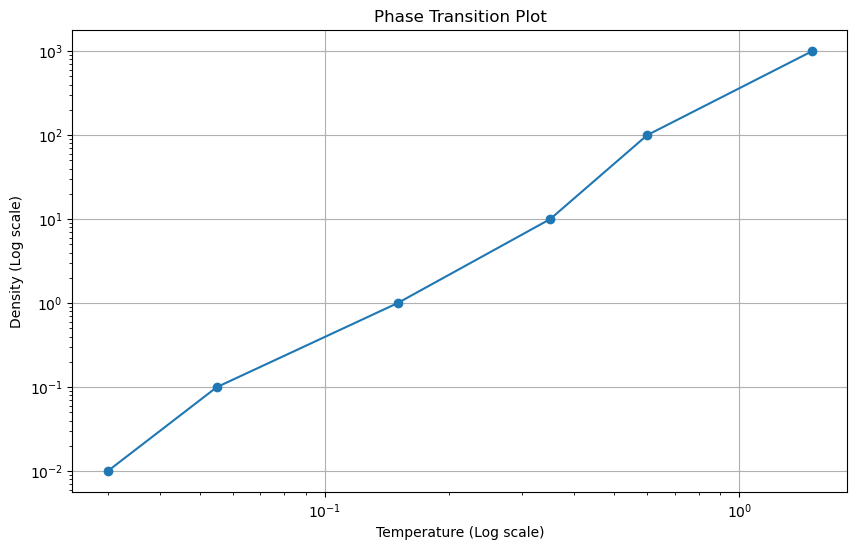

In [135]:

# Define the densities and corresponding phase transition temperatures
densities = [0.01, 0.1, 1, 10, 100, 1000]
phase_transitions = [(0.02, 0.04), (0.04, 0.07), (0.1, 0.2), (0.3, 0.4), (0.4, 0.8), (1, 2)]

# Calculate the average temperature for each phase transition
avg_temperatures = [(T_min + T_max) / 2 for T_min, T_max in phase_transitions]

# Create the plot with a logarithmic scale on both axes
plt.figure(figsize=(10, 6))
plt.loglog(avg_temperatures, densities, marker='o')

plt.xlabel('Temperature (Log scale)')
plt.ylabel('Density (Log scale)')
plt.title('Phase Transition Plot')
plt.grid(True)
plt.show()